In [1]:
%load_ext autoreload
%autoreload 2

In [53]:
%matplotlib inline

In [2]:
import sys

sys.path.extend(
    [
        'src/poultry',
    ]
)

In [76]:
import string
import json
from itertools import chain, islice
from collections import deque

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.metrics.pairwise import pairwise_distances

In [4]:
class Vectorizer:

    def __init__(self, features=string.ascii_lowercase + string.digits, length=3):
        self.all_features = set(features)
        self.all_features.add('')
        self.feature_map = {f: i for i, f in enumerate(features, start=1)}
        self.feature_map[''] = 0

        self.length = length

    def features(self, text):
        text = text.lower()
    
        features = filter(None, (self.feature_map.get(f) for f in text))
        features = chain(features, [0] * (self.length - 1))

        window = deque([0] * (self.length - 1), self.length)
        for current in features:
            window.append(current)
            yield sum(f * len(self.feature_map) ** i for i, f in enumerate(reversed(window)))
            
    def __call__(self, text):
        return np.fromiter(set(self.features(text)), int)

In [5]:
vectorizer = Vectorizer()

In [6]:
vectorizer.feature_map['a']

1

In [7]:
vectorizer('a tweet')

array([    1,  7585,  7050, 28236,  2132, 27380,    57, 31677])

In [250]:
class Collection:
    
    def __init__(self, vectorizer):
        self.vectorizer = vectorizer
        self.df = np.zeros(len(vectorizer.feature_map) ** vectorizer.length)
            
    def append(self, text):        
        features = self.vectorizer(text)
        self.df[features] += 1

        return self._idf(features)
 
    def __getitem__(self, key):
        features = self.vectorizer(key)
        return self._idf(features)

    def _idf(self, features):
        result = np.zeros(self.df.shape[0])
        result[features] = 1 / np.log(self.df[features] + 1)
        return result
        
    def distance(self, one, another, metric='cosine'):
        if isinstance(one, str):
            one = [one]
        if isinstance(another, str):
            another = [another]
        return pairwise_distances(
            list(map(self.__getitem__, one)),
            list(map(self.__getitem__, another)),
            metric=metric,
        )


In [9]:
collection = Collection(vectorizer)

In [10]:
collection.append('a tweet')

array([ 0.,  1.,  0., ...,  0.,  0.,  0.])

In [11]:
collection.append('another tweet')

array([ 0. ,  0.5,  0. , ...,  0. ,  0. ,  0. ])

In [12]:
collection['a tweet']

array([ 0. ,  0.5,  0. , ...,  0. ,  0. ,  0. ])

In [13]:
collection.distance('a tweet', 'another tweet')

array([[ 0.73986701]])

In [14]:
collection.append('some other tweet')

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [15]:
collection.distance(
    'a tweet',
    [
        'a tweet',
        'another tweet',
        'some other tweet',
    ],
)

array([[ 0.        ,  0.78610452,  0.88128212]])

In [16]:
collection.append('totally different piece')

array([ 0.,  0.,  0., ...,  0.,  0.,  0.])

In [17]:
collection.distance(
    [
        'a tweet',
        'another tweet',
        'some other tweet',
        'totally different piece'
    ],
    [
        'a tweet',
        'another tweet',
        'some other tweet',
        'totally different piece'
    ],
).round(3)

array([[ 0.   ,  0.786,  0.881,  1.   ],
       [ 0.786,  0.   ,  0.713,  1.   ],
       [ 0.881,  0.713,  0.   ,  1.   ],
       [ 1.   ,  1.   ,  1.   ,  0.   ]])

In [18]:
from poultry import readline_dir

In [19]:
tweets = list(islice(readline_dir('tweets/hydrate/RTS17/'), 10))

In [209]:
def Tweets(limit=10):
    for tweet in islice(readline_dir('tweets/hydrate/RTS17/'), limit):
        if tweet.lang == 'en' and not tweet.is_spam:
            yield tweet

In [136]:
with open('eval/RTS17/topics.json') as f:
    topics = json.load(f)
topics = [topics[-22], topics[2]]
queries = [t['title'] for t in topics]

In [137]:
fina_tweets = [
    """Bronze butterfly: Daiya Seto took his 3rd straight #FINAWorlds medal on Wednesday.http://bit.ly/2u0KN4V""",
    """China's medal haul at 2017 FINA World Championships: 12 gold, 12 silver and 6 bronze. Follow us for more.""",
    """2017 FINA World Championships: Day 8 Prelims Live Recap https://swimswam.com/2017-fina-world-championships-day-8-prelims-live-recap/ …""",
    
    """Athletics: Everything you need to know about South African athletes at World Championships http://buff.ly/2uYp8hn""",
]

In [138]:
fina_collection = Collection(vectorizer)

In [139]:
for item in fina_tweets + queries:
    fina_collection.append(item)

In [140]:
fina_collection.distance(fina_tweets, topics[0]['title'])

array([[ 0.98910261],
       [ 0.96073846],
       [ 0.95432931],
       [ 0.97301864]])

In [317]:
qrels = pd.read_csv(
    'eval/RTS17/eval_qrelsfile',
    sep=' ',
    names=['topic', 'q0', 'tweet_id', 'judgment'],
    usecols=['topic', 'tweet_id', 'judgment'],
    header=None,
    index_col=['tweet_id', 'topic'],
    squeeze=True,
).unstack('topic')

qrels = pd.concat([qrels], axis=1, keys=['Relevance'])

In [381]:
%%time
tweet_collection = Collection(vectorizer)

for q in queries:
    tweet_collection.append(q)

similarities = pd.DataFrame.from_records(
    (
        (tweet.id, *distances)
        for i, tweet, vector, distances in (
            (
                i, tweet,
                tweet_collection.append(tweet.text),
                tweet_collection.distance(tweet.text, queries, metric='cosine').flatten()
            )
            for i, tweet in enumerate(Tweets(1_000_000))
        )
#         if min(distances) < 0.9
    ),
    columns=['tweet_id', *[t['topid'] for t in topics]],
    index='tweet_id',
)

similarities = pd.concat([similarities], axis=1, keys=['Score'])

similarities = similarities.merge(
    qrels, how='left',
    left_index=True, right_index=True,
)[[('Score', 'RTS212'), ('Score', 'RTS48'), ('Relevance', 'RTS212'), ('Relevance', 'RTS48')]]

CPU times: user 10min 9s, sys: 6.91 s, total: 10min 16s
Wall time: 10min 22s


In [518]:
similarities['Relevance'].apply(lambda c: c.value_counts())

Topic,RTS212,RTS48
-2.0,1,1.0
0.0,21,9.0
1.0,11,NaN


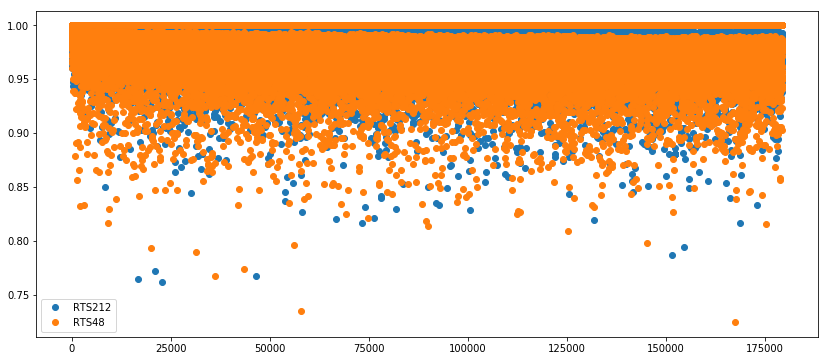

In [383]:
similarities['Score'].plot(style='o', use_index=False, figsize=(14, 6))

In [393]:
similarities.sort_values(
    [
        ('Score', 'RTS212'),
        ('Score', 'RTS48'),
        ('Relevance', 'RTS212'),
        ('Relevance', 'RTS48'),
    ][0],
    ascending=True,
)[:10]

Score           Relevance      
                      RTS212     RTS48    RTS212 RTS48
tweet_id                                              
891157466876170240  0.761941  0.981241       NaN   NaN
891154279171543041  0.764378  0.988529       NaN   NaN
891170230109691904  0.767349  1.000000       NaN   NaN
891156544099831808  0.771610  0.967868       NaN   NaN
891241709438464000  0.786541  0.935598       1.0   NaN
891243936630624256  0.794450  1.000000       NaN   NaN
891186088810827776  0.816185  1.000000       NaN   NaN
891253881321250816  0.816788  0.899696       NaN   NaN
891226878396313600  0.819078  1.000000       NaN   NaN
891181911267319809  0.819844  0.966238       NaN   NaN

In [494]:
zzz = similarities.dropna('rows', how='all', subset=[('Relevance', 'RTS212'), ('Relevance', 'RTS48')]).fillna(-3)

zzz.columns.names = ['Type', 'Topic']
zzz = zzz.stack('Topic')
zzz = zzz.reset_index('Topic')

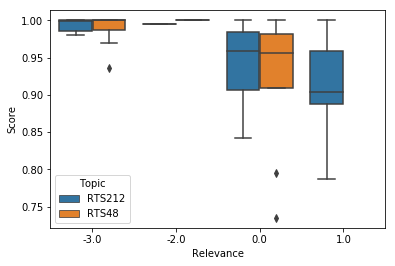

In [495]:
sns.boxplot(data=zzz, x='Relevance', y='Score', hue='Topic');